In [86]:
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(2022294)

In [87]:
# Loading the dataset
data = np.load("mnist.npz")

# Check the shapes of the loaded arrays
x_train = data['x_train']
y_train = data['y_train']
x_test = data["x_test"]
y_test = data["y_test"]

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [88]:
# Selecting classes 0,1 and 2 from the original data
x_train_new = []
y_train_new = []
for digit in range(3):
    select_digit = np.where(y_train==digit)[0]
    for i in select_digit:
        x_train_new.append(x_train[i])
        y_train_new.append(y_train[i])
x_train_new = np.array(x_train_new)
print("Shape of X train new:",x_train_new.shape)

y_train_new = np.array(y_train_new)
print("Shape of Y train new:",y_train_new.shape)

#Reshape the training dataset
x_train_flat = x_train_new.reshape(-1, 784)
print("Reshaped dimension of new X train:", x_train_flat.shape)

Shape of X train new: (18623, 28, 28)
Shape of Y train new: (18623,)
Reshaped dimension of new X train: (18623, 784)


In [89]:
#Computing covariance ,eigenvectors and eigenvalue. Applying PCA on the centralized PCA.
x_train_centered = x_train_flat - np.mean(x_train_flat, axis=0)
num_of_samples = 18623
cov_matrix = np.dot(x_train_centered.T, x_train_centered) / (num_of_samples -1)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
sort_ind = np.argsort(eigenvalues)[::-1] #Sorting in descending order
sorted_eigenvalues = eigenvalues[sort_ind]
U = eigenvectors[:, sort_ind]
print("Shape of U:", U.shape)

Shape of U: (784, 784)


In [90]:
#Applying PCA to reduce the dimension to p=10
Up = U[:, :10]
Yp = np.dot(Up.T, x_train_centered.T)
Xrecon_p = np.dot(Up, Yp).T + np.mean(x_train_flat, axis=0)
Xrecon_p = Xrecon_p.T
print(Yp.shape) 
print("Shape of the reconstructed image:",Xrecon_p.shape)

(10, 18623)
Shape of the reconstructed image: (784, 18623)


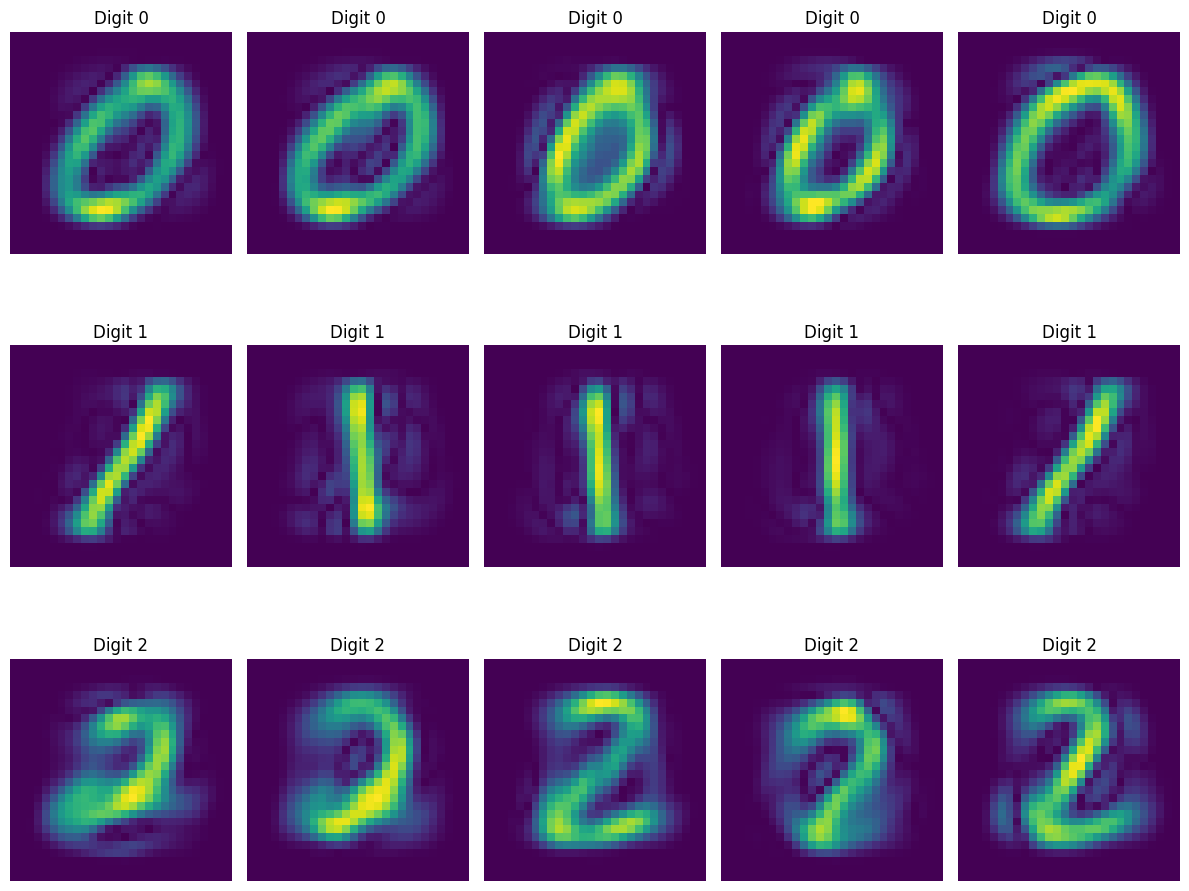

In [91]:
# Visualize 5 samples from each class in the train set in the form of images.
fig, axes = plt.subplots(3, 5, figsize=(12, 10))
for digit in range(3):
    digit_indices = np.where(y_train_new == digit)[0][:5] 
    for i, index in enumerate(digit_indices):
        img_to_display = np.abs(Xrecon_p.T[index].reshape(28, 28)).astype(np.float32)
        axes[digit, i].imshow(img_to_display)
        axes[digit, i].set_title(f"Digit {digit}")
        axes[digit, i].axis('off')

plt.tight_layout()
plt.show()


In [92]:
# Learning Decision Tree form the given dataset

#Calculating gini index using formula 1 - p1**2 - p2**2 - ... - pn**2
def gini_index(y):
    if len(y)==0:
        return 0
    p_y = np.bincount(y)/len(y)
    return np.sum(p_y*(1-p_y))

# #After getting all the gini indices we calculate the best split region
def best_split_region(x,y):
    best_gini = float('inf')
    best_dim, best_split = None, None

    for dim in range(x.shape[1]):
        # For each dimension, the function computes unique threshold values (split points) based on the unique values in that dimension 
        thresholds = np.unique(x[:, dim])
        for split in thresholds:
            left_region = np.where(x[:, dim] <= split)[0]
            right_region = np.where(x[:, dim] > split)[0]
            gini_left = gini_index(y[left_region])
            gini_right = gini_index(y[right_region])
            gini = (len(left_region) * gini_left + len(right_region) * gini_right) / len(y)
            if gini < best_gini:
                best_gini = gini
                best_dim = dim
                best_split = split
    return best_dim, best_split

def best_split_region_mean(x, y):
    best_gini = float('inf')
    best_dim, best_split = None, None

    for dim in range(x.shape[1]):
        split = np.mean(x[:, dim])
        left_region = np.where(x[:, dim] <= split)[0]
        right_region = np.where(x[:, dim] > split)[0]
        gini_left = gini_index(y[left_region])
        gini_right = gini_index(y[right_region])
        gini = (len(left_region) * gini_left + len(right_region) * gini_right) / len(y)
        
        if gini < best_gini:
            best_gini = gini
            best_dim = dim
            best_split = split

    return best_dim, best_split
 
def classification_tree(X, y, max_depth=2, depth=0):
    if len(np.unique(y)) == 1 or depth == max_depth:
        return np.argmax(np.bincount(y))

    best_dim, best_split = best_split_region_mean(X, y)
    left_split_indices = np.where(X[:, best_dim] <= best_split)[0]
    right_split_indices = np.where(X[:, best_dim] > best_split)[0]

    #Choose randomly between left (0) or right (1) to be a terminal node.
    terminate = random.choice([0,1])
    terminate = 0
    if terminate==1:
        left_subtree = np.argmax(np.bincount(y[left_split_indices]))
        right_subtree = classification_tree(X[right_split_indices], y[right_split_indices], max_depth, depth + 1)
    else:
        left_subtree = classification_tree(X[left_split_indices], y[left_split_indices], max_depth, depth + 1)
        right_subtree = np.argmax(np.bincount(y[right_split_indices]))

    return {'split_dim': best_dim, 'split_value': best_split, 'left': left_subtree, 'right': right_subtree}

train_tree = classification_tree(Yp.T, y_train_new, max_depth=2)
print("Decision tree:", train_tree)


Decision tree: {'split_dim': 0, 'split_value': (8.439063763430274e-14+0j), 'left': {'split_dim': 1, 'split_value': (38.5110992608933+0j), 'left': 0, 'right': 2}, 'right': 1}


In [93]:
# Apply PCA to reduce dimensionality of test set
x_test_flat = x_test.reshape(-1,784)
x_test_centered = x_test_flat - np.mean(x_test_flat,axis=0)
class_mask_test = np.isin(y_test, [0, 1, 2])
x_test_new = x_test_centered[class_mask_test]
y_test_new = y_test[class_mask_test]

cov_matrix_test = np.dot(x_test_centered.T, x_test_centered) / (x_test_new.shape[0]-1)
eigenvalues_test, eigenvectors_test = np.linalg.eig(cov_matrix_test)
sort_ind_test = np.argsort(eigenvalues_test)[::-1] #Sorting in descending order
sorted_eigenvalues = eigenvalues_test[sort_ind_test]
U_test = eigenvectors[:, sort_ind_test]
print("Shape of U test:", U_test.shape)

Up_test = U_test[:, :10]
Yp_test = np.dot(Up_test.T, x_test_new.T)
Xrecon_p_test = np.dot(Up_test, Yp_test)
print(Yp_test.shape)
print("Shape of the reconstructed image:",Xrecon_p_test.shape)

Shape of U test: (784, 784)
(10, 3147)
Shape of the reconstructed image: (784, 3147)


In [94]:
#Testing the tree and computing the predicted classes
predicted_classes = []
for test_pt in Yp_test.T:
    tree = train_tree
    while isinstance(tree, dict):
        dim = tree['split_dim']
        if test_pt[dim] <= tree['split_value']:
            tree = tree['left']
        else:
            tree = tree['right']
    predicted_classes.append(tree)
print(y_test_new)
print(predicted_classes)
        

[2 1 0 ... 0 1 2]
[1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 0, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 0, 0, 2, 1, 1, 0, 1, 2, 2, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1, 1, 1, 0, 2, 2, 0, 2, 1, 1, 1, 2, 0, 1, 0, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 0, 

In [95]:
#Computing test accuracy
correct = np.sum(y_test_new==predicted_classes)
print("Overall accuracy:", correct/len(y_test_new))

Overall accuracy: 0.7667619955513187


In [96]:
#Computing Class-wise accuracy
class_acc = []
for digit in range(3):
    digit_index = np.where(digit == y_test_new)[0]
    correct = 0
    for i in digit_index:
        if (y_test_new[i]==predicted_classes[i]):
            correct+=1
    class_acc.append(correct / len(digit_index))
print("Class-wise accuracy:")
print("Accuracy of Class 0:",class_acc[0])
print("Accuracy of Class 1:",class_acc[1])
print("Accuracy of Class 2:",class_acc[2])

Class-wise accuracy:
Accuracy of Class 0: 0.8479591836734693
Accuracy of Class 1: 0.9991189427312775
Accuracy of Class 2: 0.43410852713178294


In [97]:
#Creating 5 bags from original
total_sample = len(x_train_flat)
print(total_sample)
index_1 = [random.randint(0, total_sample - 1) for i in range(total_sample)]
index_2 = [random.randint(0, total_sample - 1) for i in range(total_sample)]
index_3 = [random.randint(0, total_sample - 1) for i in range(total_sample)]
index_4 = [random.randint(0, total_sample - 1) for i in range(total_sample)]
index_5 = [random.randint(0, total_sample - 1) for i in range(total_sample)]

X1 = Yp.T[index_1]
X2 = Yp.T[index_2]
X3 = Yp.T[index_3]
X4 = Yp.T[index_4]
X5 = Yp.T[index_5]

Y1 = y_train_new[index_1]
Y2 = y_train_new[index_2]
Y3 = y_train_new[index_3]
Y4 = y_train_new[index_4]
Y5 = y_train_new[index_5]

print(index_1)
print(index_2)
print(index_3)

18623
[1370, 2120, 18568, 4892, 2636, 10180, 11285, 2554, 16096, 17397, 6934, 4647, 137, 4272, 7831, 5119, 3527, 3447, 9224, 13155, 6080, 818, 15646, 18116, 1102, 4741, 5381, 17519, 17136, 12622, 14148, 9721, 11523, 15094, 17179, 10254, 14214, 6959, 14606, 1381, 654, 3948, 9502, 715, 7684, 10396, 5996, 6100, 10240, 8376, 2526, 17241, 4492, 15246, 564, 2136, 7342, 17028, 405, 15402, 9307, 2777, 9838, 128, 9002, 16699, 13499, 15252, 11674, 13616, 8655, 5291, 14745, 2899, 12120, 15929, 3834, 13095, 331, 12109, 1223, 13165, 17195, 15353, 12713, 773, 128, 10230, 2741, 14289, 9928, 18280, 755, 16102, 11184, 18243, 7944, 2304, 566, 9335, 7385, 16324, 10260, 16564, 14983, 3374, 10337, 15482, 1808, 14054, 14765, 328, 11347, 3464, 5303, 16988, 17230, 10707, 1307, 8144, 7544, 1446, 5370, 2103, 13347, 8603, 1149, 14569, 9802, 17751, 15258, 4300, 14747, 4731, 3381, 5342, 16400, 9536, 4316, 8839, 11087, 13066, 1961, 14515, 3694, 5850, 10849, 2846, 1017, 13933, 13163, 3325, 11094, 7001, 12926, 13285,

In [98]:
#Training trees for each dataset 
tree_1 = classification_tree(X1,Y1,max_depth=2,depth=0)
tree_2 = classification_tree(X2,Y2,max_depth=2,depth=0)
tree_3 = classification_tree(X3,Y3,max_depth=2,depth=0)
tree_4 = classification_tree(X4,Y4,max_depth=2,depth=0)
tree_5 = classification_tree(X5,Y5,max_depth=2,depth=0)

print("Tree 1:",tree_1)
print("Tree 2:",tree_2)
print("Tree 3:",tree_3)
print("Tree 4:",tree_4)
print("Tree 5:",tree_5)

Tree 1: {'split_dim': 0, 'split_value': (-8.820318689727701+0j), 'left': {'split_dim': 1, 'split_value': (28.844118041170976+0j), 'left': 0, 'right': 2}, 'right': 1}
Tree 2: {'split_dim': 0, 'split_value': (10.209509262222271+0j), 'left': {'split_dim': 1, 'split_value': (43.150880761764384+0j), 'left': 0, 'right': 2}, 'right': 1}
Tree 3: {'split_dim': 0, 'split_value': (-2.4401968293021707+0j), 'left': {'split_dim': 1, 'split_value': (30.056136195225225+0j), 'left': 0, 'right': 2}, 'right': 1}
Tree 4: {'split_dim': 0, 'split_value': (-3.774422993516212+0j), 'left': {'split_dim': 1, 'split_value': (36.26520985530302+0j), 'left': 0, 'right': 2}, 'right': 1}
Tree 5: {'split_dim': 0, 'split_value': (5.9849520690112845+0j), 'left': {'split_dim': 1, 'split_value': (58.15905328299764+0j), 'left': 0, 'right': 2}, 'right': 1}


In [99]:
#Prediction
trees = [tree_1,tree_2,tree_3,tree_4,tree_5]
predictions = []
for test_pt in Yp_test.T:
    pred = []
    votes= {}
    for num in trees:
        tree = num
        while isinstance(tree, dict):
            dim = tree['split_dim']
            if test_pt[dim] <= tree['split_value']:
                tree = tree['left']
            else:
                tree = tree['right']
        if tree in votes:
            votes[tree] += 1
        else:
            votes[tree] = 1
    freq_vote = max(zip(votes.values(),votes.keys()))[1]
    predictions.append(freq_vote)
print(predictions)
print(predicted_classes)
print(y_test_new)

#Computing test accuracy
correct_bag = np.sum(y_test_new==predictions)
print("Overall accuracy:", correct_bag/len(y_test_new))

#Computing Class-wise accuracy
class_acc = []
for digit in range(3):
    digit_index = np.where(digit == y_test_new)[0]
    correct = 0
    for i in digit_index:
        if (y_test_new[i]==predictions[i]):
            correct+=1
    class_acc.append(correct / len(digit_index))
print("Class-wise accuracy:")
print("Accuracy of Class 0:",class_acc[0])
print("Accuracy of Class 1:",class_acc[1])
print("Accuracy of Class 2:",class_acc[2])

[1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 0, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 0, 0, 2, 1, 1, 0, 1, 2, 2, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1, 1, 1, 0, 2, 2, 0, 2, 1, 1, 1, 2, 0, 1, 0, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 1, 1, 1, 0, 1, 